# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

****Описание этапа обработки****

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

****Описание данных****

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План работы

1. Загрузить и изучить имеющиеся данные.Обработать пропуски заполнением нолями данных о подаче сыпучих и о подаче сыпучих материалов (объём).Удалим строки с  температуры и подаче сыпучих и о подаче сыпучих материалов (объём) с аномальными данными. Столбец с температорой переведем из типа float в тип int.
2. Создадим общий дата фрейм со всеми признаками путем группировки по столбцу "key" и далее сделаем данный столбец индексом для слияния датафремов,затем разделить на тренировачную и тестовую выборки в соотношении 1:3, выделив целевой признак-конечную температуру.

3. Обучить несколько моделей на имеющихся данных (Линейная регрессия, Регрессор ЛГБМ, CatBoost Regressor)
4. Оценить наиболее модель давшую наиболее точные резуальтыта на тестовой выборке.
5. Написание отчета по проделанной работе.

План необходимо основные действия, метод объединения таблиц написанть например или способ заполнения пропусков и т.д.

#### Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

#### Обьявим переменные

In [2]:
RANDOM_STATE = 240423
CVC=5
TEST_SIZE=0.25

#### Загрузим датасеты

In [3]:
try:
    data_arc=pd.read_csv('datasets/final_steel/data_arc.csv')
    data_bulk=pd.read_csv('datasets/final_steel/data_bulk.csv')
    data_bulk_time=pd.read_csv('datasets/final_steel/data_bulk_time.csv')
    data_gas=pd.read_csv('datasets/final_steel/data_gas.csv')
    data_temp=pd.read_csv('datasets/final_steel/data_temp.csv')
    data_wire=pd.read_csv('datasets/final_steel/data_wire.csv')
    data_wire_time=pd.read_csv('datasets/final_steel/data_wire_time.csv')
except:
    data_arc=pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk=pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time=pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas=pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp=pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire=pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time=pd.read_csv('/datasets/final_steel/data_wire_time.csv')


In [4]:
def show_info(scv):
    display(scv.head(15))
    display(scv.info())
    display(scv.describe())
    return


#### Выведем статистические данные об электродах

In [5]:
show_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


#### Построим гистограмму для мощности

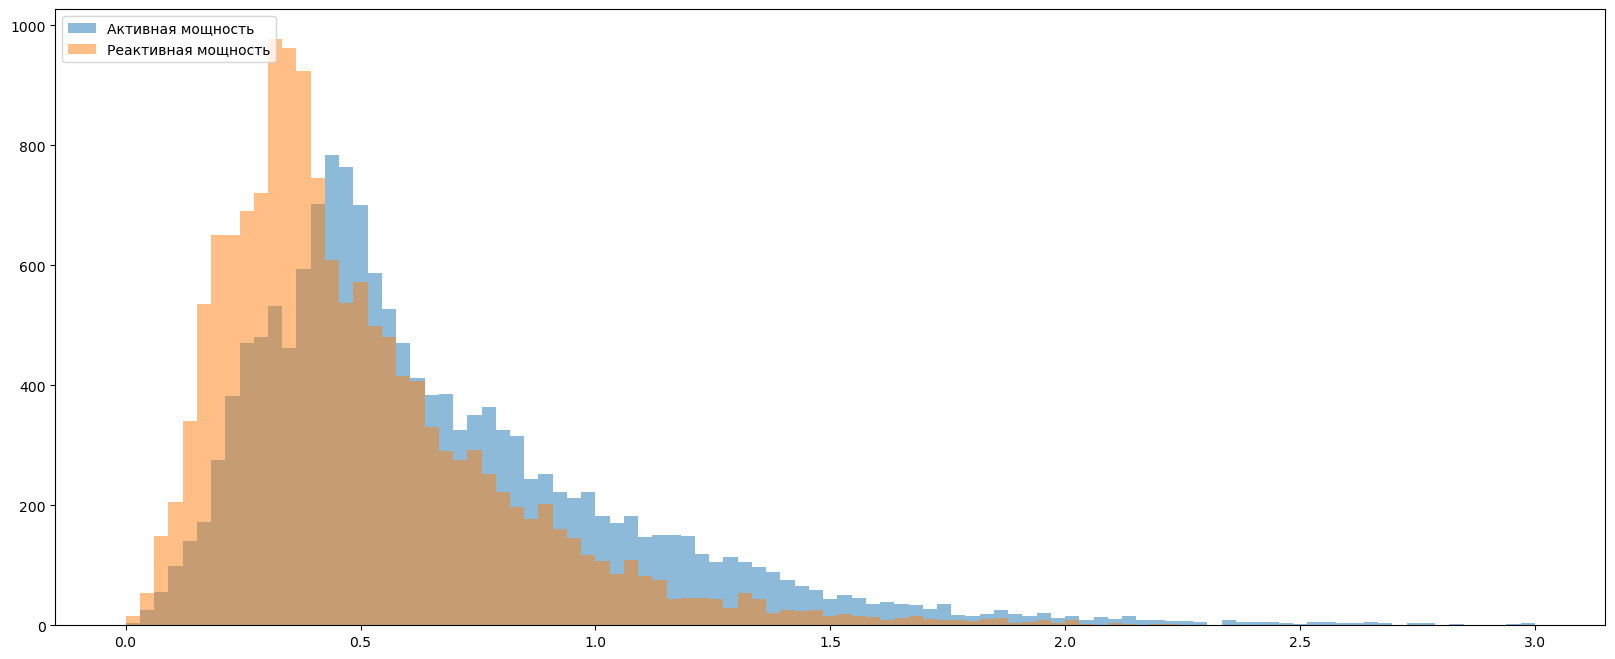

In [6]:
bins = np.linspace(0, 3, 100)
plt.figure(figsize=(20,8),edgecolor='blue')
plt.hist(data_arc['Активная мощность'], bins, alpha = 0.5, label='Активная мощность')
plt.hist(data_arc['Реактивная мощность'], bins, alpha = 0.5, label='Реактивная мощность')
plt.legend(loc='upper left')
plt.show()

##### Вывод:Распределение мощностей нормальное со смещением влево. При этом имеються аномальные значения реактивной мощности(-715.504924)

#### Выведем статистические данные о подаче сыпучих материалов (объём)

In [7]:
show_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


#### Построим диаграммы размаха для данных о подаче сыпучих материалов (объём)

<AxesSubplot: >

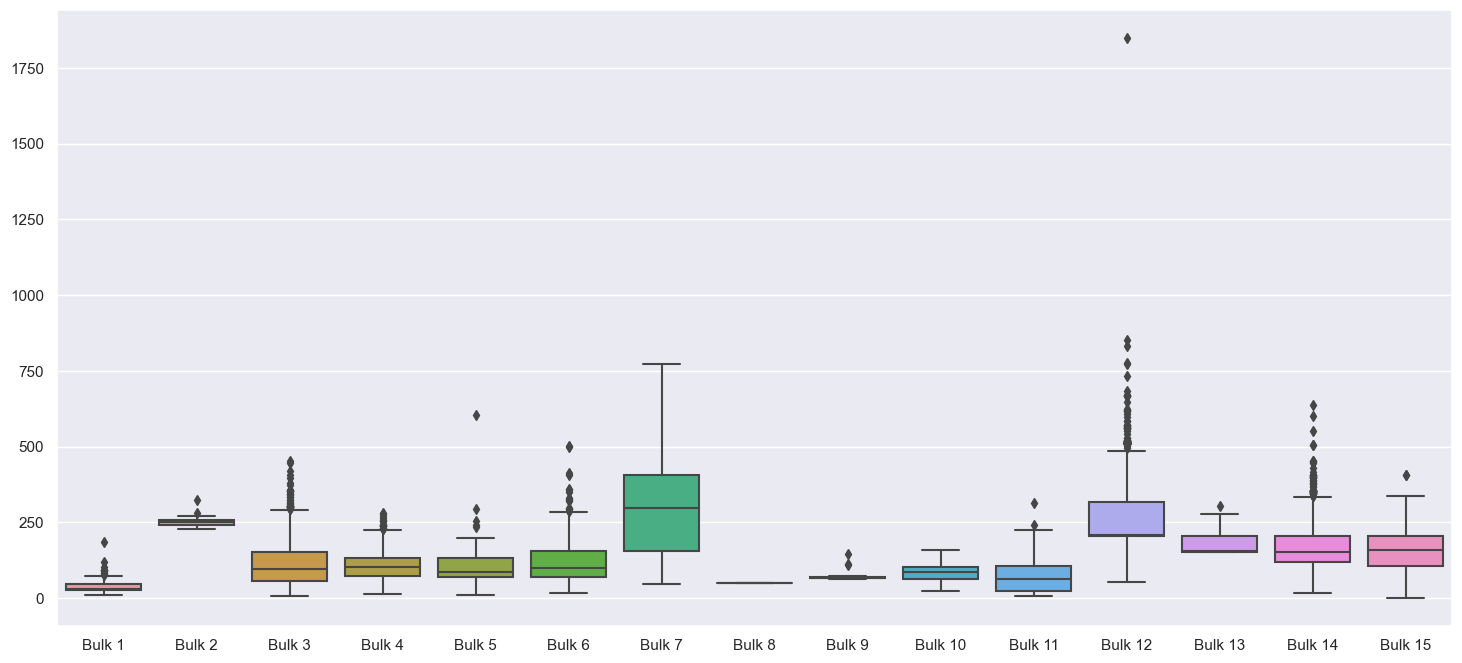

In [8]:
sns.set(rc={'figure.figsize':(18,8)})
sns.boxplot(data=data_bulk.drop(['key'], axis=1))

##### Вывод: На диаграммах рассеяния видны аномальные значения для столбцов "Bulk 5" и "Bulk 12". Данные выходящие за границы усов можно оставить, поскольку возможно они связаны с технологией производства. 

#### Выведем статистические данные о подаче сыпучих материалов (время)

In [9]:
show_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


##### Вывод: Время подачи сыпучих материалов в датафреме представлено в виде строки, необходим перевод в тип date.

#### Выведем статистические данные о продувке сплава газом

In [10]:
show_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


##### Посроим гистограмму о продувке сплава газом

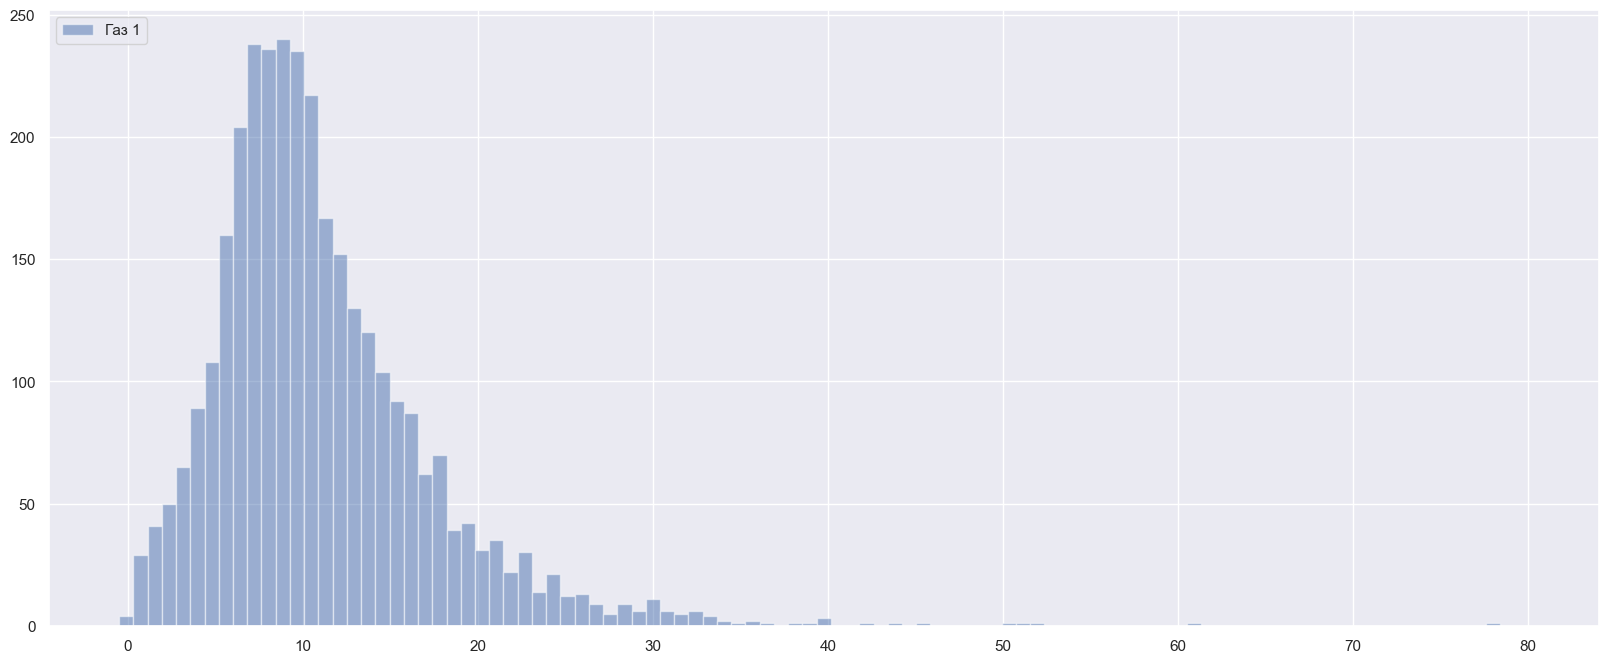

In [11]:
bins = np.linspace(-0.5, 80, 100)
plt.figure(figsize=(20,8),edgecolor='blue')
plt.hist(data_gas['Газ 1'], bins, alpha = 0.5, label='Газ 1')
plt.legend(loc='upper left')
plt.show()

##### Вывод: В целом распределение расхода газа иметь нормальное распределение со смещением влево.

#### Выведем статистические результаты измерения температуры;

In [12]:
show_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


##### Построим гистограмму результатов измерения температуры;

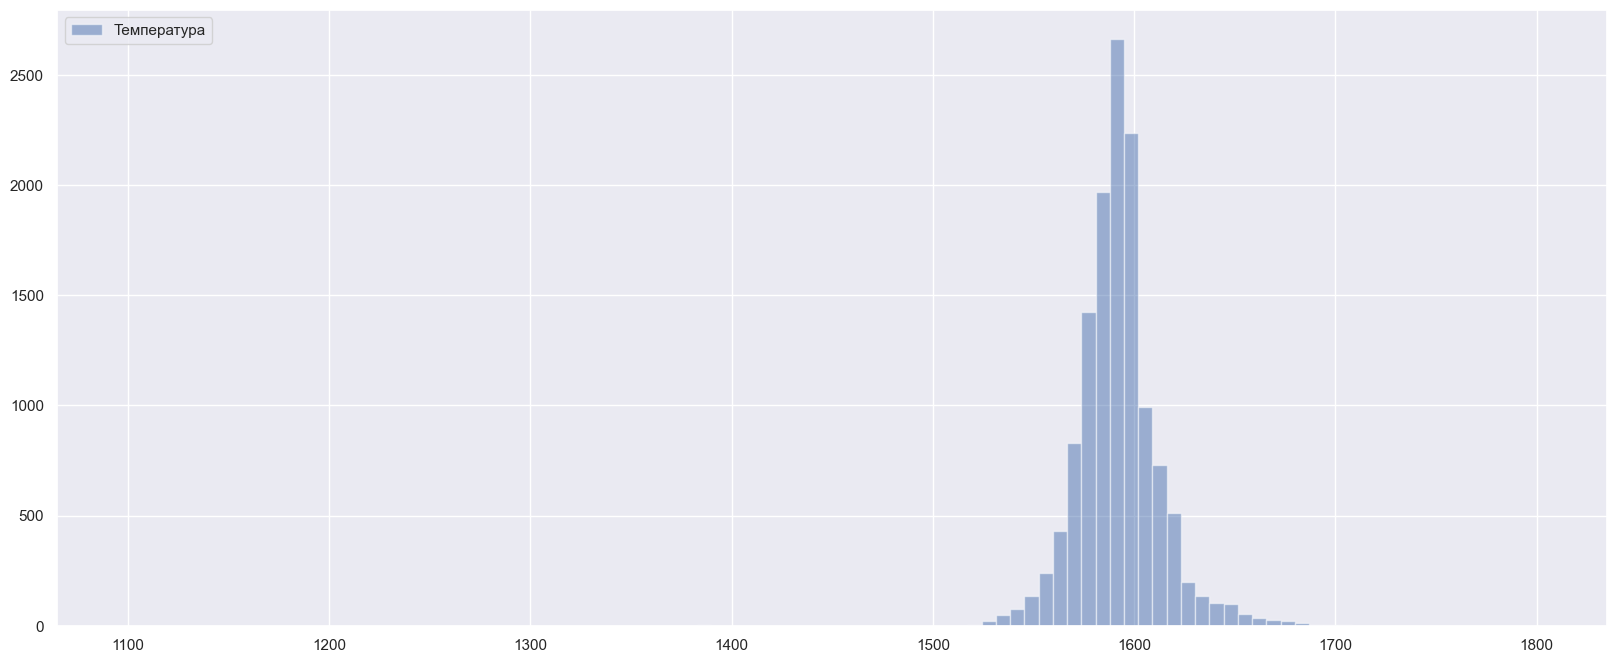

In [13]:
bins = np.linspace(1100, 1800, 100)
plt.figure(figsize=(20,8),edgecolor='blue')
plt.hist(data_temp['Температура'], bins, alpha = 0.5, label='Температура')
plt.legend(loc='upper left')
plt.show()

##### Вывод: Распределение температоруы имеет нормальное распределение, данные дата можно привести к целочисленному значению.

#### Выведем статистические данные о проволочных материалах (объём);

In [14]:
show_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


##### Построим диаграмму рассеивания для  данных о проволочных материалах (объём);

<AxesSubplot: >

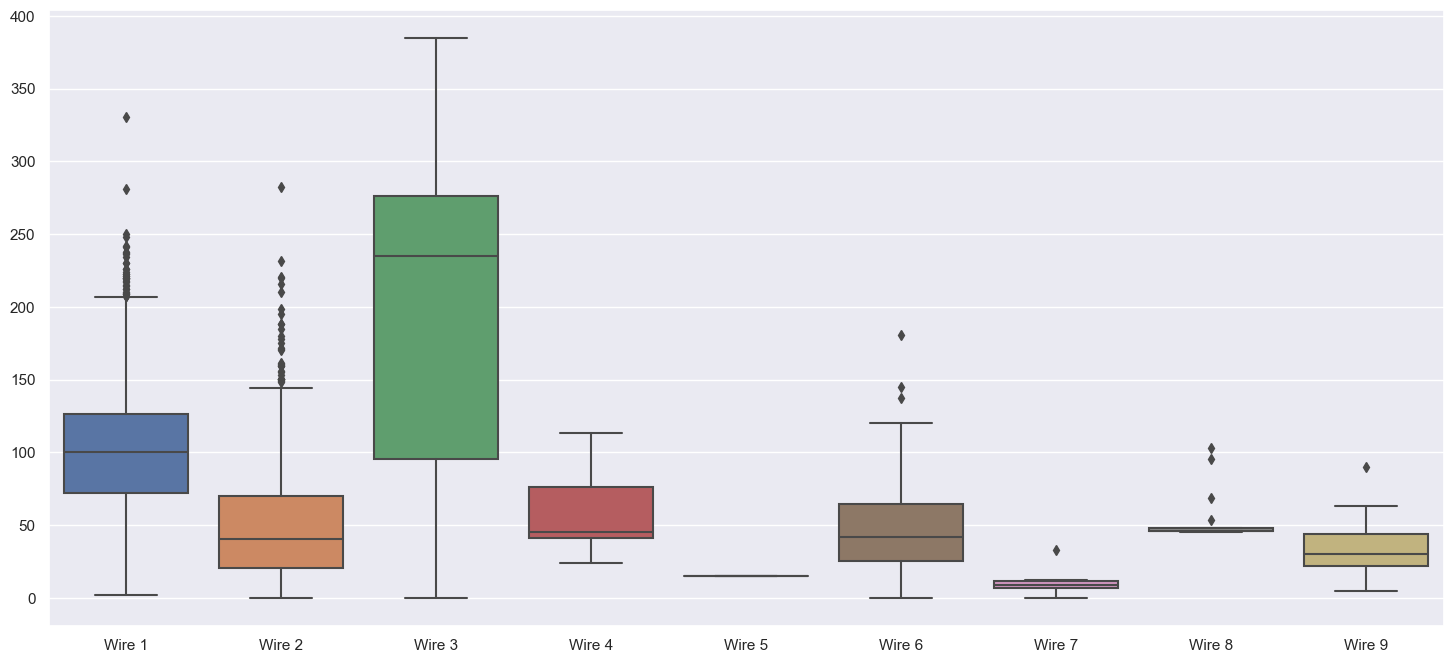

In [15]:
sns.set(rc={'figure.figsize':(18,8)})
sns.boxplot(data=data_wire.drop(['key'], axis=1))

##### Вывод: На диаграмме рассеивания видны единичные аномальные данные для столбцов "Wire 6-9". Для столбцов "Wire 1" и "Wire 2" данные выходящие за границы усов можно оставить так как они могут быть связаны с технологическим процессом.

#### Выведем статистические данные о проволочных материалах (время).

In [16]:
show_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


##### Вывод: Время подачи проволочных материалов в датафреме представлено в виде строки, необходим перевод в тип date.

### Вывод: В результате первично осмотра данных были обнаружены пропуски в данных о подаче сыпучих и проволочных материалов, а также в результатах измерения температуры. Кроме того наблюдаются аномолии замера температуры меньше 1500 градусов, при такой температуре сталь твердеет и процесс не возможен. Кроме того с помощью диаграмм рассеивания для данных о подаче сыпучих и проволочных материалов были обнаружены аномальные значения, которые необходимо исключить.

## Анализ данных

#### Откоректируем название столбцов в соответствии с требовании PEP8

In [17]:
data_arc.columns = ['key', 'start_of_the_heating','end_of_the_heating','active_power','reactive_power']
data_temp.columns = ['key', 'time_of_measurement','temperature']
data_gas.columns = ['key', 'gaz_1']
wire_list=[f'wire_{x}' for x in range(1,10)]
wire_list.insert(0,'key')
data_wire_time.columns = wire_list
data_wire.columns = wire_list
bulk_list=[f'bulk_{x}' for x in range(1,16)]
bulk_list.insert(0,'key')
data_bulk_time.columns = bulk_list
data_bulk.columns = bulk_list

#### Преобразуем текстовые данные с временем в тип datetime

In [18]:
data_temp["time_of_measurement"] = pd.to_datetime(data_temp["time_of_measurement"])
data_arc["end_of_the_heating"] = pd.to_datetime(data_arc["end_of_the_heating"])
data_arc["start_of_the_heating"] = pd.to_datetime(data_arc["start_of_the_heating"])
wire_list=[f'wire_{x}' for x in range(1,10)]
data_wire_time[wire_list] = data_wire_time[wire_list].apply(pd.to_datetime, errors='coerce')
bulk_list=[f'bulk_{x}' for x in range(1,16)]
data_bulk_time[bulk_list] = data_bulk_time[bulk_list].apply(pd.to_datetime, errors='coerce')


#### Удалим случаи когда была замерена температура ниже 1500 градусов

In [19]:
print("Количество удаленных ключей ",data_temp[data_temp['temperature']<1500]['key'].count())
list_to_delite=list(data_temp[data_temp['temperature']<1500]['key'])
data_temp=data_temp[~data_temp['key'].isin(list_to_delite)]


Количество удаленных ключей  7


#### Удалим случаи когда было всего одно измерение

In [20]:
data_temp['key_counts'] = data_temp.groupby(['key'])['key'].transform('count')
print("Количество удаленных строк ",data_temp[data_temp['key_counts']<2]['key'].count())
data_temp=data_temp[data_temp['key_counts']>1]
data_temp=data_temp.drop(['key_counts'], axis=1)

Количество удаленных строк  2


#### Откоректируем отрицательную реактивную мощность по активной мощности, из медианного соотношения мощностей.

In [21]:
idx=data_arc[data_arc['reactive_power']<0].index
median_rate=(data_arc['reactive_power']/data_arc['active_power']).median()
data_arc.loc[idx, "reactive_power"]=data_arc[data_arc['reactive_power']<0]['active_power']*median_rate

#### Определим финальную температуру- final_temperature

In [22]:
for i in data_temp['key'].unique():
    idx=data_temp[data_temp['time_of_measurement']==data_temp[data_temp['key']==i]['time_of_measurement'].max()].index
    data_temp.loc[ idx,'final_temperature']=data_temp['temperature'][idx]
data_temp_final=data_temp.dropna(subset=['final_temperature'])
data_temp_final=data_temp_final.drop(['temperature'], axis=1)
data_temp=data_temp.drop(['final_temperature'], axis=1)
data_temp_final = data_temp_final.set_index('key')
print(data_temp_final.head())

    time_of_measurement  final_temperature
key                                       
1   2019-05-03 11:30:39             1613.0
2   2019-05-03 11:59:12             1602.0
3   2019-05-03 12:34:57             1599.0
4   2019-05-03 12:59:25             1625.0
5   2019-05-03 13:36:01             1602.0


#### Определим начальную температуру

In [23]:
for i in data_temp['key'].unique():
    idx=data_temp[data_temp['time_of_measurement']==data_temp[data_temp['key']==i]['time_of_measurement'].min()].index
    data_temp.loc[ idx,'first_temperature']=data_temp['temperature'][idx]
data_temp_first=data_temp.dropna(subset=['first_temperature'])
data_temp_first=data_temp_first.drop(['temperature'], axis=1)
data_temp=data_temp.drop(['first_temperature'], axis=1)
data_temp_first = data_temp_first.set_index('key')
print(data_temp_first.head())

    time_of_measurement  first_temperature
key                                       
1   2019-05-03 11:16:18             1571.0
2   2019-05-03 11:37:27             1581.0
3   2019-05-03 12:13:17             1596.0
4   2019-05-03 12:52:57             1601.0
5   2019-05-03 13:23:19             1576.0


#### Удалим строки с указанием мощности работы электродов которые были сделаны после последнего замера температуры.

In [24]:
delite_count=1
count=1
while count > 0:
    count=0
    for i in data_temp['key'].unique():
        if (data_temp[data_temp['key']==i]['time_of_measurement'].max())<(data_arc[data_arc['key']==i]['end_of_the_heating'].max()):
            data_arc = data_arc[data_arc['end_of_the_heating'] != data_arc[data_arc['key']==i]['end_of_the_heating'].max()]
            count=count+1
    
    print('Проходка:',delite_count,'Строк удалено:',count)
    delite_count=delite_count+1

Проходка: 1 Строк удалено: 169
Проходка: 2 Строк удалено: 3
Проходка: 3 Строк удалено: 0


#### Удалим строки с указанием мощности работы электродов которые были сделаны перед первым замером температуры.

In [25]:
delite_count=1
count=1
while count > 0:
    count=0
    for i in data_temp['key'].unique():
        if (data_temp[data_temp['key']==i]['time_of_measurement'].min())>(data_arc[data_arc['key']==i]['start_of_the_heating'].min()):
            data_arc = data_arc[data_arc['start_of_the_heating'] != data_arc[data_arc['key']==i]['start_of_the_heating'].min()]
            count=count+1
    print('Проходка:',delite_count,'Строк удалено:',count)
    delite_count=delite_count+1


Проходка: 1 Строк удалено: 3157
Проходка: 2 Строк удалено: 251
Проходка: 3 Строк удалено: 32
Проходка: 4 Строк удалено: 4
Проходка: 5 Строк удалено: 1
Проходка: 6 Строк удалено: 0


#### Удалим строки с указанием расхода проволочных материалов, которые были сделаны не между замерами температуры.

In [26]:
data_wire_time = data_wire_time.set_index('key')
data_wire = data_wire.set_index('key')


In [27]:
count=0
for i in data_temp['key'].unique():
    try:
        if data_wire_time['wire_1'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_wire['wire_1'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_2'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_wire['wire_2'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_3'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_wire['wire_3'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_4'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_wire['wire_4'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_5'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_wire['wire_5'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_6'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_wire['wire_6'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_7'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_wire['wire_7'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_8'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_wire['wire_8'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_9'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_wire['wire_9'].loc[i]=0
            count=count+1
    except:
        pass
print('Строк удалено:',count)   

Строк удалено: 285


In [28]:
count=0
for i in data_temp['key'].unique():
    try:
        if data_wire_time['wire_1'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_wire['wire_1'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_2'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_wire['wire_2'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_3'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_wire['wire_3'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_4'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_wire['wire_4'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_5'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_wire['wire_5'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_6'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_wire['wire_6'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_7'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_wire['wire_7'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_8'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_wire['wire_8'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_wire_time['wire_9'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_wire['wire_9'].loc[i]=0
            count=count+1
    except:
        pass
print('Строк удалено:',count)


    

Строк удалено: 3


#### Удалим строки с указанием расхода сыпучих материалов, которые были сделаны не между замерами температуры.

In [29]:
data_bulk_time = data_bulk_time.set_index('key')
data_bulk = data_bulk.set_index('key')

In [30]:
count=0
for i in data_temp['key'].unique():

    try:
        if data_bulk_time['bulk_1'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_1'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_2'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_2'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_3'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_3'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_4'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_4'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_5'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_5'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_6'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_6'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_7'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_7'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_8'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_8'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_9'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_9'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_10'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_10'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_11'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_11'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_12'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_12'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_13'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_13'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if (data_bulk_time['bulk_14'].loc[i])<(data_temp_first['time_of_measurement'].loc[i]):
            data_bulk['bulk_14'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_15'].loc[i]<data_temp_first['time_of_measurement'].loc[i]:
            data_bulk['bulk_15'].loc[i]=0
            count=count+1
    except:
        pass
print('Строк удалено:',count)


    

Строк удалено: 1497


In [31]:
count=0
for i in data_temp['key'].unique():
    try:
        if data_bulk_time['bulk_1'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_1'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_2'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_2'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_3'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_3'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_4'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_4'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_5'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_5'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_6'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_6'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_7'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_7'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_8'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_8'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_9'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_9'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_10'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_10'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_11'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_11'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_12'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_12'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_13'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_13'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_14'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_14'].loc[i]=0
            count=count+1
    except:
        pass
    try:
        if data_bulk_time['bulk_15'].loc[i]>data_temp_final['time_of_measurement'].loc[i]:
            data_bulk['bulk_15'].loc[i]=0
            count=count+1
    except:
        pass
print('Строк удалено:',count)


Строк удалено: 9


#### Создадим новый признак-затраченная энергия на нагрев-full_energy

In [32]:
data_arc['time_of_the_heating']=(data_arc['end_of_the_heating']-data_arc['start_of_the_heating']).dt.total_seconds()
data_arc['full_power']=(data_arc['active_power']**2+data_arc['reactive_power']**2)**(0.5)
data_arc['full_energy']=data_arc['full_power']*data_arc['time_of_the_heating']
data_arc_final=pd.pivot_table(data_arc,values=['full_energy'],index='key',aggfunc={'full_energy': np.sum})
display(data_arc_final.head())

,full_energy
key,
1,838.692711
2,809.781395
3,173.239130
4,399.037156
5,824.212175


#### Создадим новый признак-время между замерами температурами-time_of_the_heating т.к. потеря температуры прямопропорционально времени

In [33]:
data_temp_first['time_of_the_heating']=(data_temp_final['time_of_measurement']-data_temp_first['time_of_measurement']).dt.total_seconds()
display(data_temp_first.head())

,time_of_measurement,first_temperature,time_of_the_heating
key,,,
1,2019-05-03 11:16:18,1571.0,861.0
2,2019-05-03 11:37:27,1581.0,1305.0
3,2019-05-03 12:13:17,1596.0,1300.0
4,2019-05-03 12:52:57,1601.0,388.0
5,2019-05-03 13:23:19,1576.0,762.0


#### Обьединим таблица по признаку key

In [34]:
data_gas = data_gas.set_index('key')
final_table = pd.concat([data_temp_final,data_temp_first,data_arc_final, data_bulk, data_gas, data_wire], axis=1, sort=False, join="inner")
display(final_table.head())
display(final_table.info())

,time_of_measurement,final_temperature,time_of_measurement,first_temperature,time_of_the_heating,full_energy,bulk_1,bulk_2,bulk_3,bulk_4,...,gaz_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,861.0,838.692711,NaN,NaN,NaN,43.0,...,29.749986,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,1305.0,809.781395,NaN,NaN,NaN,73.0,...,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,1300.0,173.239130,NaN,NaN,NaN,34.0,...,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,388.0,399.037156,NaN,NaN,NaN,0.0,...,18.841219,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,762.0,824.212175,NaN,NaN,NaN,0.0,...,5.413692,0.000000,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time_of_measurement  2299 non-null   datetime64[ns]
 1   final_temperature    2299 non-null   float64       
 2   time_of_measurement  2299 non-null   datetime64[ns]
 3   first_temperature    2299 non-null   float64       
 4   time_of_the_heating  2299 non-null   float64       
 5   full_energy          2299 non-null   float64       
 6   bulk_1               198 non-null    float64       
 7   bulk_2               13 non-null     float64       
 8   bulk_3               950 non-null    float64       
 9   bulk_4               801 non-null    float64       
 10  bulk_5               53 non-null     float64       
 11  bulk_6               431 non-null    float64       
 12  bulk_7               13 non-null     float64       
 13  bulk_8               1 non-null  

None

#### В полученной таблице мы видим, то колонка wire_5 полностью пустая, удалим ее.

In [35]:
final_table=final_table.drop(['wire_5'], axis=1)

#### Удалим строки у которых не указана финальная температура, расход электроэнергии и газа,а также столбцы не имеющие признаков. Данные расхода материалов заполним нолями.

In [36]:
final_table=final_table.drop(['time_of_measurement'], axis=1)
final_table=final_table.dropna (subset=['final_temperature'])
final_table=final_table.dropna (subset=['full_energy'])
final_table=final_table.dropna (subset=['gaz_1'])
final_table=final_table.fillna(0)
display(final_table.head())
final_table.info()

,final_temperature,first_temperature,time_of_the_heating,full_energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_15,gaz_1,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,861.0,838.692711,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,29.749986,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1602.0,1581.0,1305.0,809.781395,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1599.0,1596.0,1300.0,173.239130,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1625.0,1601.0,388.0,399.037156,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.841219,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,1602.0,1576.0,762.0,824.212175,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.413692,0.000000,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   final_temperature    2299 non-null   float64
 1   first_temperature    2299 non-null   float64
 2   time_of_the_heating  2299 non-null   float64
 3   full_energy          2299 non-null   float64
 4   bulk_1               2299 non-null   float64
 5   bulk_2               2299 non-null   float64
 6   bulk_3               2299 non-null   float64
 7   bulk_4               2299 non-null   float64
 8   bulk_5               2299 non-null   float64
 9   bulk_6               2299 non-null   float64
 10  bulk_7               2299 non-null   float64
 11  bulk_8               2299 non-null   float64
 12  bulk_9               2299 non-null   float64
 13  bulk_10              2299 non-null   float64
 14  bulk_11              2299 non-null   float64
 15  bulk_12              2299 non-null   f

#### Посмотрим тепловую карту для определения мультиколлениарности между признаками

plt.figure(figsize=(16,12)
sns.heatmap(final_table.corr(), annot=True)

#### Между bulk_9 и wire_8 имееться довольно сильная корреляция-0,97. Удалим bulk_9.

In [37]:
final_table=final_table.drop(['bulk_9'], axis=1)

#### Посмотрим какие признаки влияют на финальную температуру сильнее всего.

In [38]:
final_table.corr()['final_temperature'].abs() >= 0.1

final_temperature       True
first_temperature       True
time_of_the_heating    False
full_energy             True
bulk_1                 False
bulk_2                 False
bulk_3                 False
bulk_4                  True
bulk_5                 False
bulk_6                  True
bulk_7                  True
bulk_8                 False
bulk_10                False
bulk_11                 True
bulk_12                 True
bulk_13                False
bulk_14                 True
bulk_15                 True
gaz_1                  False
wire_1                  True
wire_2                  True
wire_3                 False
wire_4                  True
wire_6                 False
wire_7                  True
wire_8                 False
wire_9                 False
Name: final_temperature, dtype: bool

#### Разделим датасет на тренировачную и тестовую выборки

In [39]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   final_temperature    2299 non-null   float64
 1   first_temperature    2299 non-null   float64
 2   time_of_the_heating  2299 non-null   float64
 3   full_energy          2299 non-null   float64
 4   bulk_1               2299 non-null   float64
 5   bulk_2               2299 non-null   float64
 6   bulk_3               2299 non-null   float64
 7   bulk_4               2299 non-null   float64
 8   bulk_5               2299 non-null   float64
 9   bulk_6               2299 non-null   float64
 10  bulk_7               2299 non-null   float64
 11  bulk_8               2299 non-null   float64
 12  bulk_10              2299 non-null   float64
 13  bulk_11              2299 non-null   float64
 14  bulk_12              2299 non-null   float64
 15  bulk_13              2299 non-null   f

In [40]:
train_table,test_table = train_test_split(final_table,test_size=TEST_SIZE,random_state=RANDOM_STATE)


#### Удалим аномалии для столбцов которые сильнее всего влияют на окончальтельную температуру с помощью метода IsolationForest

In [41]:
model=IsolationForest(n_estimators=100, max_samples='auto',random_state=12345,contamination=0.12)
model.fit(train_table[['final_temperature','first_temperature','full_energy','bulk_6','bulk_12','wire_2','wire_4']])
train_table['is_outlier'] =  model.predict(train_table[['final_temperature','first_temperature','full_energy','bulk_6','bulk_12','wire_2','wire_4']]) == -1
outliers_isolation_forest = train_table['is_outlier'].sum()
print("Количество удаленных аномалий: ", outliers_isolation_forest)
outlier_indexes = list(train_table[train_table['is_outlier'] == 1].index)
good_indexes = list(set(train_table.index) - set(outlier_indexes))
final_table_isolation_forest = train_table.drop(outlier_indexes)
final_table_isolation_forest = final_table_isolation_forest.drop(['is_outlier'], axis=1)

Количество удаленных аномалий:  207


<font color='purpel'><b>Комментарий тимлида </b></font><br>
<font color='darkorange'>⚠️ Выбросы мы можем убрать только из тренировочной выборки, т.к. в реальности такие данные могут попадать в модель. </font>

#### Разделим выборку на тестовую и тренировачную и выделим признаки и цели

In [42]:
features_train = final_table_isolation_forest.drop('final_temperature', axis=1)
target_train = final_table_isolation_forest['final_temperature']
features_test = test_table.drop('final_temperature', axis=1)
target_test= test_table['final_temperature']



#### Обучим модель LinearRegression()

In [43]:
model_LR = LinearRegression()
cv_mae_LR = (cross_val_score(model_LR, 
                             features_train, 
                             target_train, 
                             cv=CVC, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE for Linear Regression', cv_mae_LR)

MAE for Linear Regression 5.573871781256457


#### Обучим модель LGBMRegressor()

In [44]:
model_LGBMR = LGBMRegressor() 
params = [{'num_leaves':[7, 14, 21], 
            'learning_rate':[0.1, 0.03, 0.01],
            'max_depth': [-1, 3, 5],
            'n_estimators': [175, 200, 225, 250,275],
            'random_state':[RANDOM_STATE]}]
grid_LGBMR = GridSearchCV(model_LGBMR, params, scoring='neg_mean_absolute_error', cv=CVC)
grid_LGBMR.fit(features_train, target_train)
print("Лучшие параметры подобранные GridSearchCV", grid_LGBMR.best_params_)
print('MAE for LGBMRegressor() =', grid_LGBMR.best_score_*-1)


Лучшие параметры подобранные GridSearchCV {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 275, 'num_leaves': 14, 'random_state': 240423}
MAE for LGBMRegressor() = 5.3586464416540425


#### Обучим модель RandomForestRegressor()

In [45]:
model_RFR = RandomForestRegressor() 
params = [{'criterion':['mse'],
                'n_estimators':[50,100,200,500], 
                'max_depth': [10, 30, 40, 60,80,100, None],
                'random_state':[RANDOM_STATE]}]
grid_RFR = GridSearchCV(model_RFR, params, scoring='neg_mean_absolute_error', cv=CVC)
grid_RFR.fit(features_train, target_train)
print("Лучшие параметры подобранные RandomForestRegressor", grid_RFR.best_params_)
print('MAE for RandomForestRegressor =', grid_RFR.best_score_*-1)


Лучшие параметры подобранные RandomForestRegressor {'criterion': 'mse', 'max_depth': 40, 'n_estimators': 100, 'random_state': 240423}
MAE for RandomForestRegressor = 5.591049526663194


#### Обучим модель CatBoostRegressor()

In [46]:
model_CAT = CatBoostRegressor(verbose=False,random_state=RANDOM_STATE)
cv_mae_CAT = (cross_val_score(model_CAT, 
                             features_train, 
                             target_train, 
                             cv=CVC, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE for CatBoostRegressor =', cv_mae_CAT)

MAE for CatBoostRegressor = 5.384088079632995


### Определим MAE на тестовой выборке для LGBMRegressor()¶

In [47]:
model_LGBMR.set_params(**grid_LGBMR.best_params_)
model_LGBMR.fit(features_train, target_train)
predict = model_LGBMR.predict(features_test)
test_mae_LGBMR = mean_absolute_error(predict, target_test)
print('MAE for LGBMRegressor() =', test_mae_LGBMR)

MAE for LGBMRegressor() = 6.219350133789137


### Вывод:
В данном пункте мы после обработки датасета(исключение аномалий, добавления признаков,исключения мультиколениарности) обучили четыре модели:  
LinearRegression  
RandomForestRegressor  
LGBMRegressor  
CatBoostRegressor  
Наилудшее значеие MAE на тренировачной выборке показала модель LGBMRegressor 5.358.  
На тестовой выборке значение MAE составило 6.219.
  

## Итоговый вывод:
В данном проекте мы сделали следующее:  
1. Загрузили и изучили имеющиеся данные. Обрабоботали аномалии(отрицательная реактивная мощность, температура стали меньше 1500 градусов). Заполнили нолями данных о подаче сыпучих и о подаче проволочных материалов (объём). 
2. Создали общий дата фрейм со всеми признаками путем группировки по столбцу "key" и далее сделаем данный столбец индексом для слияния датафремов,затем разделить на тренировачную и тестовую выборки в соотношении 1:3, выделив целевой признак-конечную температуру. При этом мы создали два новых признака время процесса-период между первым и последним замером температуры, а также признак-количество энергии затраченное на нагрев металла. В тренировачной выборке методом Isolation Forest мы избавились от аномалий(при n_estimators=100 и contamination=0.12 получилось минимальное значение MAE на тренировачной выборке). Кроме того после рассмотрения тепловой карты корреляции признаков была уделина колонка bulk_9, т.к. она имела относительно большую корреляцию с wire_8. Также был полностью удален столбец wire_5 так как после объединения таблиц методом concat c атрибутом inner все значения столбца были NaN.
3. Обучили несколько моделей на имеющихся данных (LinearRegression, RandomForestRegressor, CatBoostRegressor,LGBMRegressor).Для LGBMRegressor и RandomForestRegressor мы преминили GridSearchCV для поиска наилудщих параметров. Наилудшее значеие MAE на тренировачной выборке показала модель LGBMRegressor где значение MAE равно 5.358.
4. На тестовой выборке значение MAE для LGBMRegressor составило 6.219.

Тем самым мы выполнили все пункты плана работы над проектом. Наибольшие трудности у меня возникли с подбором гиперпараметров для LGBMRegressor, RandomForestRegressor и Isolation Forest т.к. на это уходила большая часть времени работы над проектом.
